In [1]:
#! pip install multiprocess --user

In [2]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.decomposition import PCA

import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import figure
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
matplotlib.rcParams.update({'font.size': 22})
import seaborn as sns

print(__doc__)

from time import time

from multiprocess import Pool
import pdb

Automatically created module for IPython interactive environment


## Read in data as csv 

In [3]:
data=pd.read_table('/Users/gracer/Google Drive/ABCD/important_txt/4Kmeans.csv', sep=',')

## Seperate by sex

In [4]:
dudes = data[data['sex'] == 0]
lady_dudes = data[data['sex'] == 1]

## Get a List of variable names

In [5]:
var_names=list(dudes.columns.values)
cols = dudes.columns
dudes.columns = ['sub','pds_ht2_y',  'pds_skin2_y',  'pds_bdyhair_y','labels_true',
            'pds_f4_2_y',  'pds_f5_y',  'pds_m4_y', 'pds_m5_y', 'interview_age', 'gender',
             'anthroheightcalc',  'anthroweightcalc',  'anthro_waist_cm',
             'hormone_scr_dhea_mean',  'hormone_scr_hse_mean',  'hormone_scr_ert_mean',  'sex']
# print(dudes)
# cols[1]

## Combine variables of interest into a single matrix

In [6]:
labels_true=dudes['labels_true'].values
subs=dudes['sub'].values
f2=dudes['pds_ht2_y'].values
f3=dudes['pds_skin2_y'].values
f4=dudes['pds_bdyhair_y'].values
f5=dudes['pds_m4_y'].values
f6=dudes['pds_m5_y'].values
f7=dudes['interview_age'].values
f8=dudes['anthroheightcalc'].values 
f9=dudes['anthroweightcalc'].values
f10=dudes['anthro_waist_cm'].values
f11=dudes['hormone_scr_dhea_mean'].values
f12=dudes['hormone_scr_hse_mean'].values
X=np.matrix(zip(f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12))

## Create a list of the variable names included in this analyses

In [7]:
names=['pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean']

## Check the data 

[(1, 917), (2, 354), (3, 14), (4, 1)]

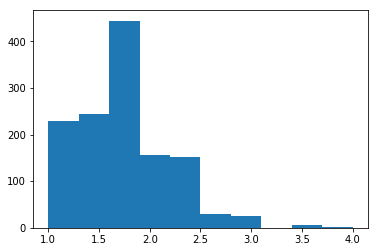

In [8]:
%matplotlib inline
plt.hist(labels_true)
y = np.bincount(labels_true.astype(int))
ii = np.nonzero(y)[0]
zip(ii,y[ii])

An issue is a low number of people in groups 3 and 4

## Possible solution, randomly sample equal numbers
Using the rule of thumb 2^m I need 8 people per cluster 
Possible combinations below

In [9]:
import math
x=math.factorial(70)
y=math.factorial(70-20)
fact=x/y
print(fact)

393849377343759797528386895216640000


## Create target variable (or the one you are comparing)

In [10]:
target_var=pd.DataFrame(dudes['labels_true'].values)
subs_var=pd.DataFrame(subs)
target_var.shape

(1286, 1)

## Impute missing values
This will not allow missing data, so have to impute nans

In [11]:
imputer = Imputer()
transformed_values = imputer.fit_transform(X)
# count the number of NaN values in each column
print(np.isnan(transformed_values).sum()) 
transformed_values_scale = scale(transformed_values)
transformed_values_scale.shape
#the target variable is the last variable
trans = np.column_stack((transformed_values_scale,subs,target_var.round(decimals=0)))

0


In [12]:
print(trans.shape)
trans[10,:]

(1286, 13)


array([1.8072925722558837, -0.76143892783116, -0.8138529876663042,
       -0.7900238054620263, -0.4657408067722271, 0.20524522333698994,
       -0.03553911606346546, -0.6818664863111453, -0.7052779366854639,
       -0.88197843756715, 1.3980210376008525e-14, 'NDAR_INV0CBPKF6W', 2.0], dtype=object)

## Function to randomly sample the data and perform the kmeans

In [13]:
def bench_k_means(estimator, name, data):
        t0 = time() #time
        estimator.fit(data) #estimating the fit 
        print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
              % (name, (time() - t0), estimator.inertia_,
                 metrics.homogeneity_score(labels, estimator.labels_),
                 metrics.completeness_score(labels, estimator.labels_),
                 metrics.v_measure_score(labels, estimator.labels_),
                 metrics.adjusted_rand_score(labels, estimator.labels_),
                 metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
                 metrics.silhouette_score(data, estimator.labels_,
                                          metric='euclidean',
                                          sample_size=sample_size)))


In [14]:
def meaner(**kwargs):
    for x in kwargs.items():
        print(x)
#     z=sum(*arg)/len(*arg)
#     return z

In [15]:
def PCA_reducer(DATA):
    n_samples, n_features = DATA.shape
    labels = np.round(targets)
    n_digits = len(np.unique(targets))
    sample_size=n_samples
    
    PCA_results = PCA(n_components=2)
    reduced_data = PCA_results.fit_transform(DATA)
    
    # Dump components relations with features:
    print pd.DataFrame(PCA_results.components_,index = ['PC-1','PC-2'])
    plt.semilogy(PCA_results.explained_variance_ratio_, '--o')
    return (PCA_results.components_, PCA_results.explained_variance_ratio_, 
            PCA_results.explained_variance_, PCA_results.mean_) 
    


In [16]:
def split_list(a_list):
        half = len(a_list)/2
        return a_list[:half], a_list[half:]

In [17]:
def random_selct(DATA):
    dictr = {}
    #defining the levels, based on the final column add the values to the dictionary
    levels = ['lev1','lev2','lev3']
    i=1
    for lev in levels:
        if i < len(levels)+1:
            dictr[lev] = DATA[np.where(DATA[:,-1] == i)]
            i=i+1
    '''
    make dictionaries to populate each run per parallel run
    '''
    rand_dict={}
    target_dict={}
    ind_dict={}
    sub_dict = {}
    '''
    subsetting the data and putting it into a dictionary
    '''
    for key, value in dictr.iteritems():
        #shuffle the data's index
        ind = np.random.permutation(value.shape[0])#random index
        #get the first 20 subjects indexes
        training_idx = ind[:50]#get 20 subjects indexes
        #get the first 20 subjects
        '''
        this needs to be the number of variables/factors you are expecting
        for females this is 12!!!!
        '''
        value_data = value[:,0:11]
        '''
        for females this is 13!!!!
        '''
        sub_data = value[:,11]
        label_data = value[:,-1]
        training = value_data[training_idx,:]#select 20 subjects from the value in the dictionary
        subs = sub_data[training_idx]
        labels_true = label_data[training_idx]
        #saving the true labels
        target_dict[key] = labels_true #add targets to dictionary
        rand_dict[key] = training #match the randomized data to the ind_dict by key 
        ind_dict[key] = training_idx #add the indexes to the dictionary
        sub_dict[key] = subs
    '''
    combine all the dictionaries we have created thus far. 
    data, index, and targets
    '''    
    list_dicts = [rand_dict, target_dict, ind_dict, sub_dict]
    list_names  = ['rand_dict', 'target_dict', 'ind_dict', 'sub_dict']
    all_dicts = {}
    i = 0
    for d in list_dicts:
        all_dicts[list_names[i]] = list_dicts[i]
        i = i +1
#         print(all_dicts['rand_dict'])
   
    '''
    combine the randomized data by the actual level
    '''
    data=np.vstack((rand_dict['lev1'],rand_dict['lev2'],rand_dict['lev3']))
    '''
    defining the parameters for the k means and the PCA
    '''
    targets=np.hstack((target_dict['lev1'],target_dict['lev2'],target_dict['lev3']))
    targets = targets.astype('int')
    n_samples, n_features = data.shape
    n_digits = len(np.unique(targets))
    sample_size=n_samples
    '''
    defining the parameters for the k means
    '''    
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=300)
    ks=kmeans.fit_predict(data)
    indexes=np.hstack((ind_dict['lev1'],ind_dict['lev2'],ind_dict['lev3']))
    subses=np.hstack((sub_dict['lev1'],sub_dict['lev2'],sub_dict['lev3']))
    list_together = [indexes, subses, ks, targets,data]
    '''
    IMPORTANT ALL THE DATA INDEXED WITH SUBJECTS
    '''
    all_together = np.column_stack(list_together)
    print(all_together.shape)
    ###################################################
    
    
    ###########################################
    #            rebuild to combine data      #
    ###########################################
    comb_data = np.column_stack((data, kmeans.fit_predict(data)))
    comb_dictr = {}
    '''
    seperating the data based on the fit predict value (found right above)
    '''
    i=0
    for lev in levels:
        if i < len(levels)+1:
            comb_dictr[lev] = comb_data[np.where(comb_data[:,-1] == i)]
            i=i+1
    '''
    defining the parameters for the PCA and running the PCA 
    '''
    ###########################################
    #            PCA                          #
    ###########################################
    PCA_dict={}
    PCA_data={}
    PCA_final = {}

    for key, value in comb_dictr.iteritems():
        PCA_dict[key] = PCA(n_components=2)
        #make sure the last column which is the predicted label isn't included
        PCA_data[key] = PCA_dict[key].fit_transform(value[:,0:11])
        #make sure the last column which is the predicted label isn't included
        ID = np.identity(value[:,0:11].shape[1])  # identity matrix
        coef = PCA_dict[key].transform(ID)
        PCA_final[key] = coef
        
        
        plt.semilogy(PCA_dict[key].explained_variance_ratio_, '--o', label = '%s'%key)
        plt.legend()
        plt.subplot(1, 2, 2)

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    plt.subplot(1, 2, 1)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
#     plt.show()
    
    ####THINGS TO SAVE#############################################################################        
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)
    clusters = kmeans.fit_predict(data)
    cluster_space = kmeans.fit_transform(data)
    
    
    
    centroids = kmeans.cluster_centers_   
    
    Components = np.vstack((PCA_dict['lev1'].components_,
                            PCA_dict['lev2'].components_,PCA_dict['lev3'].components_))
    
    Var_ratio = PCA_final
    
    lev1_VarRatio = np.vstack((PCA_final['lev1']))
    lev2_VarRatio = np.vstack((PCA_final['lev2']))
    lev3_VarRatio = np.vstack((PCA_final['lev3']))
    
    ind_dict = np.hstack((ind_dict['lev1'],
                            ind_dict['lev2'],ind_dict['lev3']))
    
    ########################################################################################################
    return (clusters, cluster_space,
            centroids,targets,
            all_together ,Components,
            Var_ratio, comb_data,
            lev1_VarRatio,lev2_VarRatio,lev3_VarRatio,
            kmeans,DATA)

# 0clusters
# 1cluster_space, 
# 2centroids, 
# 3targets, 
# 4all_dict,
# 5Components,
# 6Var_ratio, 
# 7full_data,
# 8lev1_VarRatio,
# 9lev2_VarRatio,
# 10lev3_VarRatio
# 11kmeans
# 12DATA

In [18]:
def main(i):
    names = ['pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean',
'labels_pred',
'labels_true']
    
    Clusters = []
    Cluster_space = []
    Centroids = []
    
    Comp = []
    Var_ratio = []
    
    Targets = []
    all_dicts = []
    
    Comb_data = []
    
    Lev1_VarRatio = []
    Lev2_VarRatio = []
    Lev3_VarRatio = []
    
    kmeans = []
    for x in range(0,i):
        print(x)
        Q = random_selct(trans)
        Clusters.append(Q[0])
        Cluster_space.append(Q[1])
        Centroids.append(Q[2])
        
        Targets.append(Q[3])
        all_dicts.append(Q[4])
        
        Comp.append(Q[5])
        Var_ratio.append(Q[6])
        
        Comb_data.append(Q[7])
        
        Lev1_VarRatio.append(Q[8].transpose())
        Lev2_VarRatio.append(Q[9].transpose())
        Lev3_VarRatio.append(Q[10].transpose())
        
        kmeans.append(Q[11])
        
    All_lev1Ratio = np.vstack(Lev1_VarRatio)
    All_lev2Ratio = np.vstack(Lev2_VarRatio)
    All_lev3Ratio = np.vstack(Lev3_VarRatio)
    
    All_clust = np.hstack(Clusters)
    All_clust_space = np.vstack(Cluster_space)
    
    All_labels = np.hstack(Targets)
    All_dicts = np.vstack(all_dicts)
    All_comp = np.vstack(Comp)
    All_var_ratio = Var_ratio
    All_data = np.vstack(Comb_data)
#     print(All_data)
#     print(All_data.shape)
    All_data=pd.DataFrame(data=All_data[1:,1:],index=All_data[1:,0])
    return (All_clust ,All_clust_space,
            All_labels , All_dicts,
            All_comp, All_var_ratio,
            All_data, names,
            All_lev1Ratio, All_lev2Ratio, All_lev3Ratio,
            kmeans, trans, All_dicts)
i = 5000
FINAL = []

if __name__ == "__main__": 
    pool = Pool(processes=2)
    FINAL = pool.map(main, (i,i)) 

0
0
(150, 15)
(150, 15)


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


1
1
(150, 15)
(150, 15)
2
2
(150, 15)
(150, 15)
3
3
(150, 15)
(150, 15)
4
4
(150, 15)
(150, 15)
5
5
(150, 15)
(150, 15)
6
6
(150, 15)
(150, 15)
7
7
(150, 15)
(150, 15)
8
8
(150, 15)
(150, 15)
9
9
(150, 15)
(150, 15)
10
10
(150, 15)
(150, 15)
11
11
(150, 15)
(150, 15)
12
12
(150, 15)
(150, 15)
13
13
(150, 15)
(150, 15)
14
14
(150, 15)
(150, 15)
15
15
(150, 15)
(150, 15)
16
16
(150, 15)
(150, 15)
17
17
(150, 15)
(150, 15)
18
18
(150, 15)
(150, 15)
19
19
(150, 15)
(150, 15)
20
20
(150, 15)
(150, 15)
21
21
(150, 15)
(150, 15)
22
22
(150, 15)
(150, 15)
23
23
(150, 15)
(150, 15)
24
24
(150, 15)
(150, 15)
25
25
(150, 15)
(150, 15)
26
26
(150, 15)
(150, 15)
27
27
(150, 15)
(150, 15)
28
28
(150, 15)
(150, 15)
29
29
(150, 15)
(150, 15)
30
30
(150, 15)
(150, 15)
31
31
(150, 15)
(150, 15)
32
32
(150, 15)
(150, 15)
33
33
(150, 15)
(150, 15)


/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


34
34
(150, 15)
(150, 15)
35
35
(150, 15)
(150, 15)
36
36
(150, 15)
(150, 15)
37
37
(150, 15)
(150, 15)
38
38
(150, 15)
(150, 15)
39
39
(150, 15)
(150, 15)
40
40
(150, 15)
(150, 15)
41
41
(150, 15)
(150, 15)
42
42
(150, 15)
(150, 15)
43
43
(150, 15)
(150, 15)
44
44
(150, 15)
(150, 15)
45
45
(150, 15)
(150, 15)
46
46
(150, 15)
(150, 15)
47
47
(150, 15)
(150, 15)
48
48
(150, 15)
(150, 15)
49
49
(150, 15)
(150, 15)
50
50
(150, 15)
(150, 15)
51
51
(150, 15)
(150, 15)
52
52
(150, 15)
(150, 15)
53
53
(150, 15)
(150, 15)
54
54
(150, 15)
(150, 15)
55
55
(150, 15)
(150, 15)
56
56
(150, 15)
(150, 15)
57
57
(150, 15)
(150, 15)
58
58
(150, 15)
(150, 15)
59
59
(150, 15)
(150, 15)
60
60
(150, 15)
(150, 15)
61
61
(150, 15)
(150, 15)
62
62
(150, 15)
(150, 15)
63
63
(150, 15)
(150, 15)
64
64
(150, 15)
(150, 15)
65
65
(150, 15)
(150, 15)
66
66
(150, 15)
(150, 15)
67
67
(150, 15)
(150, 15)
68
68
(150, 15)
(150, 15)
69
69
(150, 15)
(150, 15)
70
70
(150, 15)
(150, 15)
71
71
(150, 15)
(150, 15)
72
72
(150, 

331
(150, 15)
332
(150, 15)
332
(150, 15)
333
(150, 15)
333
(150, 15)
334
(150, 15)
334
(150, 15)
335
(150, 15)
335
(150, 15)
336
(150, 15)
336
(150, 15)
337
(150, 15)
337
(150, 15)
338
(150, 15)
338
(150, 15)
339
(150, 15)
339
(150, 15)
340
(150, 15)
340
(150, 15)
341
(150, 15)
341
(150, 15)
342
(150, 15)
342
(150, 15)
343
(150, 15)
343
(150, 15)
344
(150, 15)
344
(150, 15)
345
(150, 15)
345
(150, 15)
346
(150, 15)
346
(150, 15)
347
(150, 15)
347
(150, 15)
348
(150, 15)
348
(150, 15)
349
(150, 15)
349
(150, 15)
350
(150, 15)
350
(150, 15)
351
(150, 15)
351
(150, 15)
352
(150, 15)
352
(150, 15)
353
(150, 15)
353
(150, 15)
354
(150, 15)
354
(150, 15)
355
(150, 15)
355
(150, 15)
356
(150, 15)
356
(150, 15)
357
(150, 15)
357
(150, 15)
358
(150, 15)
358
(150, 15)
359
(150, 15)
359
(150, 15)
360
(150, 15)
360
(150, 15)
361
(150, 15)
361
(150, 15)
362
(150, 15)
362
(150, 15)
363
(150, 15)
363
(150, 15)
364
(150, 15)
364
(150, 15)
365
(150, 15)
365
(150, 15)
366
(150, 15)
366
(150, 15)
367
(1

(150, 15)
624
(150, 15)
625
(150, 15)
625
626
(150, 15)
(150, 15)
626
627
(150, 15)
(150, 15)
627
628
(150, 15)
(150, 15)
628
629
(150, 15)
(150, 15)
629
630
(150, 15)
(150, 15)
630
631
(150, 15)
(150, 15)
631
632
(150, 15)
(150, 15)
632
633
(150, 15)
(150, 15)
633
634
(150, 15)
(150, 15)
634
635
(150, 15)
(150, 15)
635
636
(150, 15)
(150, 15)
636
637
(150, 15)
(150, 15)
637
638
(150, 15)
(150, 15)
638
639
(150, 15)
(150, 15)
639
640
(150, 15)
(150, 15)
640
641
(150, 15)
(150, 15)
641
642
(150, 15)
(150, 15)
643
642
(150, 15)
(150, 15)
644
643
(150, 15)
(150, 15)
644
645
(150, 15)
(150, 15)
645
646
(150, 15)
(150, 15)
647
646
(150, 15)
(150, 15)
648
647
(150, 15)
(150, 15)
649
648
(150, 15)
(150, 15)
649
650
(150, 15)
(150, 15)
650
651
(150, 15)
(150, 15)
651
652
(150, 15)
(150, 15)
652
653
(150, 15)
(150, 15)
653
654
(150, 15)
(150, 15)
654
655
(150, 15)
(150, 15)
655
656
(150, 15)
(150, 15)
656
657
(150, 15)
(150, 15)
657
658
(150, 15)
(150, 15)
658
659
(150, 15)
(150, 15)
659
660
(1

(150, 15)
(150, 15)
917
918
(150, 15)
(150, 15)
918
919
(150, 15)
(150, 15)
919
920
(150, 15)
(150, 15)
920
921
(150, 15)
(150, 15)
921
922
(150, 15)
(150, 15)
922
923
(150, 15)
(150, 15)
923
924
(150, 15)
(150, 15)
924
925
(150, 15)
(150, 15)
925
926
(150, 15)
(150, 15)
926
927
(150, 15)
(150, 15)
927
928
(150, 15)
(150, 15)
928
929
(150, 15)
(150, 15)
929
930
(150, 15)
(150, 15)
930
931
(150, 15)
(150, 15)
931
(150, 15)
932
(150, 15)
932
933
(150, 15)
(150, 15)
933
934
(150, 15)
(150, 15)
934
935
(150, 15)
(150, 15)
935
936
(150, 15)
(150, 15)
937
936
(150, 15)
(150, 15)
937
938
(150, 15)
(150, 15)
938
939
(150, 15)
(150, 15)
939
940
(150, 15)
(150, 15)
940
941
(150, 15)
(150, 15)
941
942
(150, 15)
(150, 15)
942
943
(150, 15)
(150, 15)
944
943
(150, 15)
(150, 15)
945
944
(150, 15)
(150, 15)
945
946
(150, 15)
(150, 15)
946
947
(150, 15)
(150, 15)
948
947
(150, 15)
(150, 15)
949
948
(150, 15)
(150, 15)
949
950
(150, 15)
(150, 15)
950
951
(150, 15)
(150, 15)
951
952
(150, 15)
(150, 15)


1196
(150, 15)
1195
(150, 15)
1197
(150, 15)
1196
(150, 15)
1198
(150, 15)
1197
(150, 15)
1199
(150, 15)
1198
(150, 15)
1200
(150, 15)
1199
(150, 15)
1201
(150, 15)
1200
(150, 15)
1202
(150, 15)
1201
(150, 15)
1203
(150, 15)
1202
(150, 15)
1204
(150, 15)
1203
(150, 15)
1205
(150, 15)
1204
(150, 15)
1206
(150, 15)
1205
(150, 15)
1207
(150, 15)
1206
(150, 15)
1208
(150, 15)
1207
(150, 15)
1209
(150, 15)
1208
(150, 15)
1210
(150, 15)
1209
(150, 15)
1211
(150, 15)
1210
(150, 15)
1212
(150, 15)
1211
(150, 15)
1213
(150, 15)
1212
(150, 15)
1214
(150, 15)
1213
(150, 15)
1215
(150, 15)
1214
(150, 15)
1216
(150, 15)
1215
(150, 15)
1217
(150, 15)
1216
(150, 15)
1218
(150, 15)
1217
(150, 15)
1219
(150, 15)
1218
(150, 15)
1220
(150, 15)
1219
(150, 15)
1221
(150, 15)
1220
(150, 15)
1222
(150, 15)
1221
(150, 15)
1223
(150, 15)
1222
(150, 15)
1224
(150, 15)
1223
(150, 15)
1225
(150, 15)
1224
(150, 15)
1226
(150, 15)
1225
(150, 15)
1227
(150, 15)
1226
(150, 15)
1228
(150, 15)
1227
(150, 15)
1229
(150,

(150, 15)
1470
1468
(150, 15)
(150, 15)
1471
1469
(150, 15)
(150, 15)
1472
1470
(150, 15)
(150, 15)
1473
1471
(150, 15)
(150, 15)
1472
1474
(150, 15)
(150, 15)
1475
1473
(150, 15)
(150, 15)
1476
1474
(150, 15)
(150, 15)
1477
1475
(150, 15)
(150, 15)
1478
(150, 15)
1476
(150, 15)
1479
1477
(150, 15)
(150, 15)
1480
(150, 15)
1478
(150, 15)
1481
1479
(150, 15)
(150, 15)
1482
1480
(150, 15)
(150, 15)
1483
1481
(150, 15)
(150, 15)
1484
1482
(150, 15)
(150, 15)
1485
1483
(150, 15)
(150, 15)
1486
1484
(150, 15)
(150, 15)
1487
(150, 15)
1485
(150, 15)
1488
(150, 15)
1486
(150, 15)
1489
1487
(150, 15)
(150, 15)
1490
1488
(150, 15)
(150, 15)
1491
1489
(150, 15)
(150, 15)
1492
1490
(150, 15)
(150, 15)
1493
1491
(150, 15)
(150, 15)
1494
1492
(150, 15)
(150, 15)
1495
1493
(150, 15)
(150, 15)
1496
1494
(150, 15)
(150, 15)
1497
(150, 15)
1495
(150, 15)
1498
(150, 15)
1496
(150, 15)
1499
(150, 15)
1497
(150, 15)
1500
(150, 15)
1498
(150, 15)
1501
(150, 15)
1499
(150, 15)
1502
(150, 15)
1500
(150, 15)


1743
(150, 15)
1741
(150, 15)
1744
(150, 15)
1742
(150, 15)
1745
(150, 15)
1743
(150, 15)
1746
(150, 15)
1744
(150, 15)
1747
(150, 15)
1745
(150, 15)
1748
(150, 15)
1746
(150, 15)
1749
(150, 15)
1747
(150, 15)
1750
(150, 15)
1748
(150, 15)
1751
(150, 15)
1749
(150, 15)
1752
(150, 15)
1750
(150, 15)
1753
(150, 15)
1751
(150, 15)
1754
(150, 15)
1752
(150, 15)
1755
(150, 15)
1753
(150, 15)
1756
(150, 15)
1754
(150, 15)
1757
(150, 15)
1755
(150, 15)
1758
(150, 15)
1756
(150, 15)
1759
(150, 15)
1757
(150, 15)
1760
(150, 15)
1758
(150, 15)
1761
(150, 15)
1759
(150, 15)
1762
(150, 15)
1760
(150, 15)
1763
(150, 15)
1761
(150, 15)
1764
(150, 15)
1762
(150, 15)
1765
(150, 15)
1763
(150, 15)
1766
(150, 15)
1764
(150, 15)
1767
(150, 15)
1765
(150, 15)
1768
(150, 15)
1766
(150, 15)
1769
(150, 15)
1767
(150, 15)
1770
(150, 15)
1768
(150, 15)
1771
(150, 15)
1769
(150, 15)
1772
(150, 15)
1770
(150, 15)
1773
(150, 15)
1771
(150, 15)
1774
(150, 15)
1772
(150, 15)
1775
(150, 15)
1773
(150, 15)
1776
(150,

(150, 15)
2014
(150, 15)
2017
(150, 15)
2015
(150, 15)
2018
(150, 15)
2016
(150, 15)
2019
(150, 15)
2017
(150, 15)
2020
(150, 15)
2018
(150, 15)
2021
(150, 15)
2019
(150, 15)
2022
(150, 15)
2020
(150, 15)
2023
(150, 15)
2021
(150, 15)
2024
(150, 15)
2022
(150, 15)
2025
(150, 15)
2023
(150, 15)
2026
(150, 15)
2024
2027
(150, 15)
(150, 15)
2025
2028
(150, 15)
(150, 15)
2026
2029
(150, 15)
(150, 15)
2027
2030
(150, 15)
(150, 15)
2028
2031
(150, 15)
(150, 15)
2029
(150, 15)
2032
(150, 15)
2030
(150, 15)
2033
(150, 15)
2031
(150, 15)
2034
(150, 15)
2032
(150, 15)
2035
(150, 15)
2033
(150, 15)
2036
(150, 15)
2034
(150, 15)
2037
(150, 15)
2035
(150, 15)
2038
(150, 15)
2036
(150, 15)
2039
(150, 15)
2037
2040
(150, 15)
(150, 15)
2038
2041
(150, 15)
(150, 15)
2039
2042
(150, 15)
(150, 15)
2040
2043
(150, 15)
(150, 15)
2041
2044
(150, 15)
(150, 15)
2042
(150, 15)
2045
(150, 15)
2043
(150, 15)
2046
(150, 15)
2044
2047
(150, 15)
(150, 15)
2045
2048
(150, 15)
(150, 15)
2046
2049
(150, 15)
(150, 15)


2290
2287
(150, 15)
(150, 15)
2291
2288
(150, 15)
(150, 15)
2292
2289
(150, 15)
(150, 15)
2293
(150, 15)
2290
(150, 15)
2294
(150, 15)
2291
(150, 15)
2295
(150, 15)
2292
(150, 15)
2296
(150, 15)
2293
(150, 15)
2297
(150, 15)
2294
(150, 15)
2298
(150, 15)
2295
(150, 15)
2299
(150, 15)
2296
(150, 15)
2300
(150, 15)
2297
(150, 15)
2301
(150, 15)
2298
(150, 15)
2302
(150, 15)
2299
(150, 15)
2303
(150, 15)
2300
(150, 15)
2304
2301
(150, 15)
(150, 15)
2305
2302
(150, 15)
(150, 15)
2306
2303
(150, 15)
(150, 15)
2307
2304
(150, 15)
(150, 15)
2308
(150, 15)
2305
(150, 15)
2309
(150, 15)
2306
(150, 15)
2310
(150, 15)
2307
(150, 15)
2311
(150, 15)
2308
(150, 15)
2312
2309
(150, 15)
(150, 15)
2313
2310
(150, 15)
(150, 15)
2314
2311
(150, 15)
(150, 15)
2315
(150, 15)
2312
(150, 15)
2316
(150, 15)
2313
(150, 15)
2317
(150, 15)
2314
(150, 15)
2318
2315
(150, 15)
(150, 15)
2319
2316
(150, 15)
(150, 15)
2320
2317
(150, 15)
(150, 15)
2321
2318
(150, 15)
(150, 15)
2322
2319
(150, 15)
(150, 15)
2320
2323


(150, 15)
2560
(150, 15)
2564
(150, 15)
2561
(150, 15)
2565
(150, 15)
2562
(150, 15)
2566
(150, 15)
2563
(150, 15)
2567
(150, 15)
2564
(150, 15)
2568
(150, 15)
2565
(150, 15)
2569
(150, 15)
2566
(150, 15)
2570
(150, 15)
2567
(150, 15)
2571
(150, 15)
2568
(150, 15)
2572
(150, 15)
2569
(150, 15)
2573
(150, 15)
2570
(150, 15)
2574
(150, 15)
2571
(150, 15)
2575
(150, 15)
2572
(150, 15)
2576
(150, 15)
2573
(150, 15)
2577
(150, 15)
2574
(150, 15)
2578
(150, 15)
2575
(150, 15)
2579
(150, 15)
2576
(150, 15)
2580
(150, 15)
2577
(150, 15)
2581
(150, 15)
2578
(150, 15)
2582
(150, 15)
2579
(150, 15)
2583
(150, 15)
2580
(150, 15)
2584
(150, 15)
2581
(150, 15)
2585
(150, 15)
2582
(150, 15)
2586
(150, 15)
2583
(150, 15)
2587
(150, 15)
2584
(150, 15)
2588
(150, 15)
2585
(150, 15)
2589
(150, 15)
2586
(150, 15)
2590
(150, 15)
2587
(150, 15)
2591
(150, 15)
2588
(150, 15)
2592
(150, 15)
2589
(150, 15)
2593
(150, 15)
2590
(150, 15)
2594
(150, 15)
2591
(150, 15)
2595
(150, 15)
2592
(150, 15)
2596
(150, 15)


2833
(150, 15)
2837
(150, 15)
2834
(150, 15)
2838
(150, 15)
2835
2839
(150, 15)
(150, 15)
2836
2840
(150, 15)
(150, 15)
2837
(150, 15)
2841
(150, 15)
2838
(150, 15)
2842
(150, 15)
2839
(150, 15)
2843
(150, 15)
2840
2844
(150, 15)
(150, 15)
2841
2845
(150, 15)
(150, 15)
2842
2846
(150, 15)
(150, 15)
2843
2847
(150, 15)
(150, 15)
2844
2848
(150, 15)
(150, 15)
2845
2849
(150, 15)
(150, 15)
2850
2846
(150, 15)
(150, 15)
2847
2851
(150, 15)
(150, 15)
2848
2852
(150, 15)
(150, 15)
2853
2849
(150, 15)
(150, 15)
2850
2854
(150, 15)
(150, 15)
2855
2851
(150, 15)
(150, 15)
2852
2856
(150, 15)
(150, 15)
2853
(150, 15)
2857
(150, 15)
2854
(150, 15)
2858
(150, 15)
2855
(150, 15)
2859
(150, 15)
2856
(150, 15)
2860
(150, 15)
2861
2857
(150, 15)
(150, 15)
2858
2862
(150, 15)
(150, 15)
2859
2863
(150, 15)
(150, 15)
2860
2864
(150, 15)
(150, 15)
2861
2865
(150, 15)
(150, 15)
2862
2866
(150, 15)
(150, 15)
2863
(150, 15)
2867
(150, 15)
2864
(150, 15)
2868
(150, 15)
2865
(150, 15)
2869
(150, 15)
2866
2870


(150, 15)
3106
(150, 15)
3111
(150, 15)
3107
(150, 15)
3112
3108
(150, 15)
(150, 15)
3113
3109
(150, 15)
(150, 15)
3110
3114
(150, 15)
(150, 15)
3111
3115
(150, 15)
(150, 15)
3112
3116
(150, 15)
(150, 15)
3117
3113
(150, 15)
(150, 15)
3118
3114
(150, 15)
(150, 15)
3119
3115
(150, 15)
(150, 15)
3120
3116
(150, 15)
(150, 15)
3121
3117
(150, 15)
(150, 15)
3122
(150, 15)
3118
(150, 15)
3123
(150, 15)
3119
(150, 15)
3124
(150, 15)
3120
(150, 15)
3125
(150, 15)
3121
(150, 15)
3126
(150, 15)
3122
(150, 15)
3127
(150, 15)
3123
(150, 15)
3128
(150, 15)
3124
(150, 15)
3129
(150, 15)
3125
(150, 15)
3130
(150, 15)
3126
(150, 15)
3131
(150, 15)
3127
(150, 15)
3132
(150, 15)
3128
(150, 15)
3133
3129
(150, 15)
(150, 15)
3134
3130
(150, 15)
(150, 15)
3135
3131
(150, 15)
(150, 15)
3136
(150, 15)
3132
(150, 15)
3137
3133
(150, 15)
(150, 15)
3138
3134
(150, 15)
(150, 15)
3139
3135
(150, 15)
(150, 15)
3140
(150, 15)
3136
(150, 15)
3141
(150, 15)
3137
(150, 15)
3142
(150, 15)
3138
(150, 15)
3143
(150, 15)


3379
(150, 15)
3384
(150, 15)
3380
(150, 15)
3385
(150, 15)
3381
(150, 15)
3386
(150, 15)
3382
(150, 15)
3387
(150, 15)
3383
(150, 15)
3388
(150, 15)
3384
(150, 15)
3389
(150, 15)
3385
(150, 15)
3390
(150, 15)
3386
(150, 15)
3391
(150, 15)
3387
(150, 15)
3392
(150, 15)
3388
(150, 15)
3393
(150, 15)
3389
(150, 15)
3394
(150, 15)
3390
(150, 15)
3395
(150, 15)
3391
(150, 15)
3396
(150, 15)
3392
(150, 15)
3397
(150, 15)
3393
(150, 15)
3398
(150, 15)
3394
(150, 15)
3399
(150, 15)
3395
(150, 15)
3400
(150, 15)
3396
(150, 15)
3401
(150, 15)
3397
(150, 15)
3402
(150, 15)
3398
(150, 15)
3403
(150, 15)
3399
(150, 15)
3404
(150, 15)
3400
(150, 15)
3405
(150, 15)
3401
(150, 15)
3406
(150, 15)
3402
(150, 15)
3407
(150, 15)
3403
(150, 15)
3408
(150, 15)
3404
(150, 15)
3409
(150, 15)
3405
(150, 15)
3410
(150, 15)
3406
(150, 15)
3411
(150, 15)
3407
(150, 15)
3412
(150, 15)
3408
(150, 15)
3413
(150, 15)
3409
(150, 15)
3414
(150, 15)
3410
(150, 15)
3415
(150, 15)
3411
3416
(150, 15)
(150, 15)
3412
(150,

3657
(150, 15)
(150, 15)
3658
3653
(150, 15)
(150, 15)
3659
3654
(150, 15)
(150, 15)
3660
3655
(150, 15)
(150, 15)
3661
3656
(150, 15)
(150, 15)
3662
3657
(150, 15)
(150, 15)
3663
3658
(150, 15)
(150, 15)
3664
3659
(150, 15)
(150, 15)
3665
3660
(150, 15)
(150, 15)
3666
3661
(150, 15)
(150, 15)
3667
3662
(150, 15)
(150, 15)
3668
3663
(150, 15)
(150, 15)
3669
3664
(150, 15)
(150, 15)
3670
3665
(150, 15)
(150, 15)
3666
3671
(150, 15)
(150, 15)
3667
3672
(150, 15)
(150, 15)
3668
3673
(150, 15)
(150, 15)
3669
3674
(150, 15)
(150, 15)
3675
3670
(150, 15)
(150, 15)
3676
3671
(150, 15)
(150, 15)
3677
3672
(150, 15)
(150, 15)
3678
3673
(150, 15)
(150, 15)
3679
3674
(150, 15)
(150, 15)
3675
3680
(150, 15)
(150, 15)
3681
3676
(150, 15)
(150, 15)
3682
3677
(150, 15)
(150, 15)
3683
3678
(150, 15)
(150, 15)
3679
3684
(150, 15)
(150, 15)
3680
3685
(150, 15)
(150, 15)
3681
3686
(150, 15)
(150, 15)
3682
3687
(150, 15)
(150, 15)
3683
3688
(150, 15)
(150, 15)
3689
3684
(150, 15)
(150, 15)
3690
3685
(150,

(150, 15)
(150, 15)
3926
3931
(150, 15)
(150, 15)
3932
3927
(150, 15)
(150, 15)
3928
3933
(150, 15)
(150, 15)
3934
3929
(150, 15)
(150, 15)
3935
3930
(150, 15)
(150, 15)
3931
3936
(150, 15)
(150, 15)
3932
3937
(150, 15)
(150, 15)
3933
3938
(150, 15)
(150, 15)
3934
3939
(150, 15)
(150, 15)
3935
3940
(150, 15)
(150, 15)
3941
3936
(150, 15)
(150, 15)
3937
3942
(150, 15)
(150, 15)
3938
3943
(150, 15)
(150, 15)
3939
3944
(150, 15)
(150, 15)
3940
3945
(150, 15)
(150, 15)
3946
3941
(150, 15)
(150, 15)
3947
3942
(150, 15)
(150, 15)
3948
3943
(150, 15)
(150, 15)
3944
3949
(150, 15)
(150, 15)
3945
3950
(150, 15)
(150, 15)
3946
3951
(150, 15)
(150, 15)
3947
3952
(150, 15)
(150, 15)
3948
3953
(150, 15)
(150, 15)
3954
3949
(150, 15)
(150, 15)
3955
3950
(150, 15)
(150, 15)
3956
3951
(150, 15)
(150, 15)
3957
3952
(150, 15)
(150, 15)
3958
3953
(150, 15)
(150, 15)
3954
3959
(150, 15)
(150, 15)
3955
3960
(150, 15)
(150, 15)
3956
3961
(150, 15)
(150, 15)
3957
3962
(150, 15)
(150, 15)
3958
3963
(150, 15)


4198
(150, 15)
4204
4199
(150, 15)
(150, 15)
4205
4200
(150, 15)
(150, 15)
4206
4201
(150, 15)
(150, 15)
4207
4202
(150, 15)
(150, 15)
4208
4203
(150, 15)
(150, 15)
4209
(150, 15)
4204
(150, 15)
4210
(150, 15)
4205
(150, 15)
4211
(150, 15)
4206
(150, 15)
4212
(150, 15)
4207
(150, 15)
4213
(150, 15)
4208
(150, 15)
4214
(150, 15)
4209
(150, 15)
4215
(150, 15)
4210
(150, 15)
4216
(150, 15)
4211
(150, 15)
4217
(150, 15)
4212
(150, 15)
4218
(150, 15)
4213
(150, 15)
4219
(150, 15)
4214
(150, 15)
4220
(150, 15)
4215
(150, 15)
4221
(150, 15)
4216
(150, 15)
4222
(150, 15)
4217
(150, 15)
4223
(150, 15)
4218
(150, 15)
4224
(150, 15)
4219
(150, 15)
4225
(150, 15)
4220
(150, 15)
4226
(150, 15)
4221
(150, 15)
4227
(150, 15)
4222
(150, 15)
4228
(150, 15)
4223
(150, 15)
4229
(150, 15)
4224
(150, 15)
4230
(150, 15)
4225
(150, 15)
4231
(150, 15)
4226
(150, 15)
4232
(150, 15)
4227
(150, 15)
4233
(150, 15)
4228
(150, 15)
4234
(150, 15)
4229
(150, 15)
4235
(150, 15)
4230
(150, 15)
4236
(150, 15)
4231
(150,

(150, 15)
4477
(150, 15)
4472
(150, 15)
4478
(150, 15)
4473
(150, 15)
4479
(150, 15)
4474
(150, 15)
4480
(150, 15)
4475
(150, 15)
4481
(150, 15)
4476
(150, 15)
4482
(150, 15)
4477
(150, 15)
4483
(150, 15)
4478
(150, 15)
4484
(150, 15)
4479
(150, 15)
4485
(150, 15)
4480
(150, 15)
4486
(150, 15)
4481
(150, 15)
4487
(150, 15)
4482
(150, 15)
4488
(150, 15)
4483
(150, 15)
4489
(150, 15)
4484
(150, 15)
4490
(150, 15)
4485
(150, 15)
4491
(150, 15)
4486
(150, 15)
4492
(150, 15)
4487
(150, 15)
4493
(150, 15)
4488
(150, 15)
4494
(150, 15)
4489
(150, 15)
4495
(150, 15)
4490
(150, 15)
4496
(150, 15)
4491
(150, 15)
4497
(150, 15)
4492
(150, 15)
4498
(150, 15)
4493
4499
(150, 15)
(150, 15)
4494
(150, 15)
4500
(150, 15)
4495
(150, 15)
4501
(150, 15)
4496
(150, 15)
4502
(150, 15)
4497
(150, 15)
4503
(150, 15)
4498
(150, 15)
4504
(150, 15)
4499
(150, 15)
4505
(150, 15)
4500
(150, 15)
4506
(150, 15)
4501
(150, 15)
4507
(150, 15)
4502
(150, 15)
4508
(150, 15)
4503
(150, 15)
4509
(150, 15)
4504
(150, 15)


(150, 15)
(150, 15)
4745
4751
(150, 15)
(150, 15)
4746
4752
(150, 15)
(150, 15)
4747
(150, 15)
4753
(150, 15)
4748
4754
(150, 15)
(150, 15)
4749
4755
(150, 15)
(150, 15)
4750
4756
(150, 15)
(150, 15)
4751
4757
(150, 15)
(150, 15)
4752
4758
(150, 15)
(150, 15)
4753
4759
(150, 15)
(150, 15)
4754
4760
(150, 15)
(150, 15)
4761
4755
(150, 15)
(150, 15)
4756
4762
(150, 15)
(150, 15)
4757
4763
(150, 15)
(150, 15)
4758
4764
(150, 15)
(150, 15)
4759
(150, 15)
4765
(150, 15)
4760
(150, 15)
4766
(150, 15)
4761
4767
(150, 15)
(150, 15)
4762
4768
(150, 15)
(150, 15)
4763
4769
(150, 15)
(150, 15)
4770
4764
(150, 15)
(150, 15)
4771
(150, 15)
4765
(150, 15)
4772
4766
(150, 15)
(150, 15)
4767
4773
(150, 15)
(150, 15)
4774
4768
(150, 15)
(150, 15)
4769
4775
(150, 15)
(150, 15)
4770
4776
(150, 15)
(150, 15)
4771
4777
(150, 15)
(150, 15)
4772
4778
(150, 15)
(150, 15)
4779
4773
(150, 15)
(150, 15)
4780
4774
(150, 15)
(150, 15)
4781
4775
(150, 15)
(150, 15)
4782
4776
(150, 15)
(150, 15)
4783
4777
(150, 15)


In [19]:
(FINAL[0][3]).shape

(750000, 15)

In [20]:
variables = ['All_clust' ,'All_clust_space',
             'All_labels' , 'All_dat',
             'All_comp', 'All_var_ratio',
             'All_data', 'names',
             'All_lev1Ratio', 'All_lev2Ratio',
             'All_lev3Ratio', 'kmeans', 'DATA','All_dicts']
# a, b in x

dict1 ={}
dict2 ={}
dicts = [dict1, dict2]
print(len(FINAL))
i=0
for item in FINAL:
    dicti = dicts[i]
    i=i+1
    ii= 0
    for value in item:
        dicti[variables[ii]] = value
        ii=ii+1

2


In [ ]:
dict2['All_dat'].shape

(750000, 15)

In [ ]:
ds = [dict1, dict2]
d = {}
for k in dict1.iterkeys():
    d[k] = tuple(d[k] for d in ds)

All_lev1Ratio = np.vstack(d['All_lev1Ratio'])
All_lev2Ratio = np.vstack(d['All_lev2Ratio'])
All_lev3Ratio = np.vstack(d['All_lev3Ratio'])

All_clust = np.hstack(d['All_clust'])
All_clust_space = np.vstack(d['All_clust_space'])

All_labels = np.hstack(d['All_labels'])
# All_index = np.hstack(d['All_index'])

All_comp = np.vstack(d['All_comp'])
# All_var_ratio = Var_ratio

All_data = dict1['All_data'].reset_index().merge(dict2['All_data'], how="left").set_index('index')

All_DATA = np.vstack(d['DATA'])

All_dat = np.vstack(d['All_dat'])


In [ ]:
names = ['index', 'sub','predicted', 'real','pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean']
all_dat = pd.DataFrame(All_dat)
all_dat.columns = names
all_dat.set_index('index')

## Taking the variance from each K mean cluster and PCA, using PCA to find the most important factors over all

In [ ]:
names=['pds_ht2_y',
'pds_skin2_y',
'pds_bdyhair_y',
'pds_m4_y',
'pds_m5_y',
'interview_age',
'anthroheightcalc', 
'anthroweightcalc',
'anthro_waist_cm',
'hormone_scr_dhea_mean',
'hormone_scr_hse_mean']

All_Ratios = {'Lev1': All_lev1Ratio, 'Lev2': All_lev2Ratio, 'Lev3':All_lev3Ratio}
Coefs = {}
index = np.arange(11)
for key, value in All_Ratios.iteritems(): 
    pca = PCA(n_components=2)
    pca.fit_transform(value)
    i = np.identity(value.shape[1])  # identity matrix
    Coefs[key] = pca.transform(i)
    print(key)
    print pd.DataFrame(pca.components_,columns=names[0:11],index = ['PC-1','PC-2'])
    print('\n')
    
    n_groups = 11

    means_CP1 = np.absolute(pca.components_[0,:])
    std_CP1 = np.matrix.std(np.matrix(np.absolute(pca.components_[0,:])))

    means_CP2 = np.absolute(pca.components_[1,:])
    std_CP2 = np.matrix.std(np.matrix(np.absolute(pca.components_[1,:])))

    fig, ax = plt.subplots(figsize=(45, 20))
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, means_CP1, bar_width,
                    alpha=opacity, color='b',
                    yerr=std_CP1, error_kw=error_config,
                    label='Component 1')

    rects2 = ax.bar(index + bar_width, means_CP2, bar_width,
                    alpha=opacity, color='r',
                    yerr=std_CP2, error_kw=error_config,
                    label='Component 2')
    #plt.xlabel( fontsize=18)
    ax.set_xlabel('Factors', fontsize = 50)
    ax.set_ylabel('Coefficient Weight (Beta)', fontsize = 50)
    ax.set_title('Which factors are the most meaning full for %s cluster'%key, fontsize = 50)
    ax.set_xticks(index + bar_width / 2)
    
    ax.set_xticklabels(names[0:11], fontsize = 28, rotation = -15)
    ax.legend()
    ax.tick_params(labelsize = 38)

    fig=plt.figure(figsize=(100, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig.tight_layout()
    plt.show()
    

## Looking at the data

merging the original and new data sets on the indexes

In [ ]:
all_dat['real'].describe()

In [ ]:
testData = pd.DataFrame(data = dudes)
testData
# print(dudes)
# print(testData) 
total_g=pd.merge(all_dat, testData, on = ['sub'], how = 'outer')

In [ ]:
total_g

In [ ]:
total_g.to_csv('/Users/gracer/Google Drive/ABCD/important_txt/male_puberty_ana.csv', sep=',')

In [ ]:
varsy =[dudes, trans, FINAL, total_g] 

In [ ]:
all_vars = {}
keys = ['dudes','trans','FINAL','total_g'] 

for i in range(0,len(keys)):
    all_vars[keys[i]] = varsy[i]


In [ ]:
import pickle

filename = '/Users/gracer/Google Drive/ABCD/important_txt/male_data2.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(all_vars, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print all_vars == b

* All_clust (180,)<- length of the subjects over all runs
* All_clust_space(180,)<-length of the subjects over all runs
* All_means(180,)<-length of the subjects
* All_labels(180,) <- length of subjects True Labels
* All_index(180,)<-length of subjects Index of the original data
* All_comp(18, 12)<- rows are the the PCA components, times the number of the levels, and the number of runs. cols are the factors
* All_var_ratio(108, 2)<-rows are the number of runs, times the number of factors, times the number of levels
* All_var(3, 6)<- rows are the number of runs, the columns are the PCA componenets times the number of levels
* All_mean(9, 12)<- rows are the number of runs by the number of levels the columns are the number of factors
* All_data(180, 14)<-rows are the number of subjects, the columns are number of factors plus the index, plus the components

* components_ : array, shape (n_components, n_features)

* explained_variance_ratio_ : array, shape (n_components,)

*  singular_values_ : array, shape (n_components,)

*  mean_ : array, shape (n_features,)

*  n_components_ : int

*  noise_variance_ : float